<a href="https://colab.research.google.com/github/BankNatchapol/Comparison-of-Quantum-Gradient/blob/main/discrete_vs_continuous/sampling_discrete_gradient_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane
!pip install qiskit
!pip install qiskit_optimization

     |████████████████████████████████| 881 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 36.0 MB/s 
     |████████████████████████████████| 8.2 MB 18.0 MB/s 
     |████████████████████████████████| 108 kB 48.3 MB/s 
     |████████████████████████████████| 6.5 MB 4.4 MB/s 
     |████████████████████████████████| 18.0 MB 55.4 MB/s 
     |████████████████████████████████| 238 kB 40.7 MB/s 
     |████████████████████████████████| 200 kB 24.7 MB/s 
     |████████████████████████████████| 54 kB 1.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 37.5 MB 1.8 MB/s 
     |████████████████████████████████| 943 kB 24.5 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 3.6 MB 39.0 MB/s 
     |████████████████████████████████| 113 kB 29.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.2-py3-none-any.whl size=11805 

In [ ]:
import pennylane as qml
from pennylane import numpy as np

from pandas.plotting import table 
import pandas as pd
import time 

import networkx as nx
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go
import plotly.express as px

from docplex.mp.model import Model
from qiskit.opflow import Z, X, Y, I
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications import Maxcut, Clique, Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo

In [ ]:
#@title Auxilary Function
def Had(wires):
  qml.RY(np.pi/2, wires=wires)
  qml.RX(np.pi, wires=wires)


def fully_connected_layer(num_wires):
  if num_wires>1:
    for wire in range(num_wires-1):
      qml.CNOT(wires=[wire, wire+1])
    qml.CNOT(wires=[wire+1, 0])

def str2gate(gate):
  if gate == 'H':
    return Had
  elif gate == 'X':
    return qml.PauliX
  elif gate == 'Y':
    return qml.PauliY
  elif gate == 'Z':
    return qml.PauliZ
  elif gate == 'RX':
    return qml.RX
  elif gate == 'RY':
    return qml.RY
  elif gate == 'RZ':
    return qml.RZ
  else:
    assert 0, "Gate not support."

def controlStr(gate):
  if gate == 'RX':
    return qml.CNOT
  elif gate == 'RY':
    return qml.CY
  elif gate == 'RZ':
    return qml.CZ
  else:
    assert 0, "Gate not support."
    
def hamiltonian_from_qiskit(sum_op):

	'''
	This function takes a qiskit.PauliSumOp as input and
	gives back a Pennylane Hamiltonian as output

	sum_op  = qiskit.PauliSumOp

	'''
	op      = sum_op.primitive.to_list()
	n_terms = len(op)
	coeffs  = []
	paulis  = []

	for i in range(n_terms):
		paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
		coeffs.append(op[i][1].real)

	p_op = qml.Hamiltonian(coeffs,paulis)

	return p_op

def hamiltonian_from_qiskit_lcu(sum_op):

  '''
  This function takes a qiskit.PauliSumOp as input and
  gives back a Pennylane Hamiltonian as output

  sum_op  = qiskit.PauliSumOp

  '''
  op      = sum_op.primitive.to_list()
  n_terms = len(op)
  coeffs  = []
  paulis  = []

  for i in range(n_terms):
    if op[i][0]=="I":
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
    else:
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))+"Z"))
    coeffs.append(op[i][1].real)

  p_op = qml.Hamiltonian(coeffs,paulis)

  return p_op

def get_adjacency_matrix(elist):
  adjacency_matrix = np.zeros([num_wires, num_wires])

  for i,j in elist:
    adjacency_matrix[i, j] = 1.0
    adjacency_matrix[j, i] = 1.0

  return adjacency_matrix

def draw_graph(elist, colors):
  G = nx.Graph()
  #G.add_nodes_from(np.arange(0, n, 1))
  # tuple is (i,j,weight) where (i,j) is the edge
  G.add_edges_from(elist)
  pos = nx.spring_layout(G)
  default_axes = plt.axes(frameon=True)
  nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)

def int_to_binary(value, size):
  """Function that converts an integer to a binary string."""

  bi = "{0:b}".format(value)
  if len(bi)<size:
    bi = "0"*(size-len(bi)) + bi
  return bi

# **Gradient methods**

## Discrete-variable

### Parameter shift rule

In [ ]:
def parameter_shift_term(qnode, params, i, j):

    shifted = params.copy()
    
    shifted[i, j] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i, j] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

def parameter_shift(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += parameter_shift_term(qnode, params, i, j)

    return gradients

### Finite difference

In [ ]:
def finite_term(qnode, params, i, j):
    
    eps = 0.01

    shifted = params.copy()
    
    shifted[i, j] += eps
    forward = qnode(shifted)  # forward evaluation

    shifted[i, j] -= 2*eps
    backward = qnode(shifted) # backward evaluation

    return (1/(2*eps)) * (forward - backward)

def finite_difference(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += finite_term(qnode, params, i, j)

    return gradients

### Linear combination of unitaries (LCU)

In [ ]:
param_gates = ['RX', 'RY', 'RZ']

def lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers):
  qml.Hadamard(wires=num_wires)
  break_point = len(ansatz)//num_layers
  qml.adjoint(qml.S)(wires=num_wires)

  counting = 0
  for i, gate in enumerate(ansatz):
    
    if gate in param_gates:
      if i == diff_index:
        controlStr(gate)(wires=[num_wires, (diff_index//4)%4])
      str2gate(gate)(params[counting], wires=wires[i])
      counting += 1
    else:
      str2gate(gate)(wires=wires[i])
    if i!=0 and (i+1)%break_point==0:
      fully_connected_layer(num_wires)
  qml.Hadamard(wires=num_wires)

def lcu_gradients(ansatz_label, H, params, device="default.qubit", backend=None, ibmqx_token=None):
  num_layers = len(params)
  num_wires = len(H.wires)-1
  num_param_gates = len(params[0])//num_wires

  ansatz = ansatz_label * num_layers * num_wires
  
  wires = []
  for i in range(num_layers):
    for j in range(num_wires):
      for k in range(4):
        wires.append(j)
  params = params.flatten()

  if device=="default.qubit":
    dev = qml.device(device, wires=num_wires+1, shots=1024)
  else:
    dev = qml.device(device, backend=backend, wires=num_wires+1, ibmqx_token=ibmqx_token, shots=1024)
  @qml.qnode(dev)
  def lcu(ansatz, H, params, wires, diff_index):
    
    lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers)
    
    return qml.expval(H)

  gradients = []
  for i in range(len(ansatz)):
    if ansatz[i] in param_gates:
      gradients.append(lcu(ansatz, H, params, wires, i))
      
  return np.array(gradients).reshape(num_layers, -1)

### Quantum natural gradient (QNG)

In [ ]:
def quantum_natural_gradient(var, H, cost_function):
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def metric_tensor_circuit(var):
    for v in var: 
      ansatz(v, num_wires)
    return qml.expval(H)

  metric_fn = qml.metric_tensor(metric_tensor_circuit, approx="block-diag", hybrid=False)
  grad = parameter_shift(cost_function, var)
  grad_flatten = grad.flatten()
  metric_tensor = metric_fn(var)
  reg = 1e-7
  iden = np.identity(len(metric_tensor))*reg
  metric_tensor += iden
  qng_grad = np.linalg.solve(metric_tensor, grad_flatten)

  return qng_grad


### Quantum newton gradient

In [ ]:
def newton_gradient(cost_function, H, params, reg=2):
  num_layers = len(params)
  params_ori = params.copy()
  params = params.reshape(1,-1)[0]
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  def ansatz_newton(var, num_wires):
    for l in range(num_layers):
      for wire in range(num_wires):
        qml.Hadamard(wires=wire)
        qml.RX(var[0+3*wire + l*3*num_wires], wires=wire)
        qml.RY(var[1+3*wire+ l*3*num_wires], wires=wire)
        qml.RZ(var[2+3*wire+ l*3*num_wires], wires=wire)
      fully_connected_layer(num_wires)

  @qml.qnode(dev)
  def circuit(var, H):
    ansatz_newton(var, num_wires)
    return qml.expval(H)
    
  grad_fn = qml.grad(circuit)
  hes_fn = qml.jacobian(grad_fn)
  grad = parameter_shift(lambda x: cost_function(x, H), params_ori).flatten()
  hessian_matrix = hes_fn(params, H)
  iden = np.identity(len(hessian_matrix))*reg
  hessian_matrix += iden
  
  newton_grad = np.linalg.solve(hessian_matrix, grad)

  return newton_grad.reshape(num_layers,-1)
  

## Continuous-variable

### Parameter shift rule

In [ ]:
# gate_list = ['R', 'S1', 'D1']

# def parameter_shift_cv_term(qnode, params, i, j):
    
#     gate = gate_list[j%len(gate_list)]

#     shifted = params.copy()

#     if gate == 'R' or gate == 'S2' or gate == 'D2':
#       shifted[i, j] += alpha
#       forward = qnode(shifted)  # forward evaluation

#       shifted[i, j] -= 2*alpha
#       backward = qnode(shifted) # backward evaluation

#       return (1/2) * (forward - backward)

#     elif gate == 'S1':
#       shifted[i, j] += s
#       forward = qnode(shifted)  # forward evaluation

#       shifted[i, j] -= 2*s
#       backward = qnode(shifted) # backward evaluation

#       return (1/(2*np.sinh(s))) * (forward - backward)
    
#     elif gate == 'D1':
#       shifted[i, j] += s
#       forward = qnode(shifted)  # forward evaluation

#       shifted[i, j] -= 2*s
#       backward = qnode(shifted) # backward evaluation

#       return (1/(2*s)) * (forward - backward)

# def parameter_shift_cv(qnode, params):
#     gradients = np.zeros_like((params))
#     for i in range(len(gradients)):
#         for j in range(len(gradients[0])):
#             gradients[i, j] += parameter_shift_cv_term(qnode, params, i, j)

#     return gradients

### Finite difference

In [ ]:
# def finite_cv_term(qnode, params, i, j):
    
#     eps = 0.01

#     shifted = params.copy()
    
#     shifted[i, j] += eps
#     forward = qnode(shifted)  # forward evaluation

#     shifted[i, j] -= 2*eps
#     backward = qnode(shifted) # backward evaluation

#     return (1/(2*eps)) * (forward - backward)

# def finite_difference_cv(qnode, params):
#     gradients = np.zeros_like((params))
#     for i in range(len(gradients)):
#         for j in range(len(gradients[0])):
#             gradients[i, j] += finite_cv_term(qnode, params, i, j)

#     return gradients

# **Problem Fomulation** 

## Max-Cut

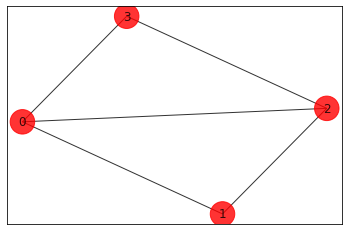

In [ ]:
num_wires = 4  # Number of nodes in graph

elist_maxcut = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
colors_maxcut = ["r" for node in range(num_wires)]

draw_graph(elist_maxcut, colors_maxcut)

In [ ]:
adjacency_matrix_maxcut = get_adjacency_matrix(elist_maxcut)
max_cut = Maxcut(adjacency_matrix_maxcut)
qp_maxcut = max_cut.to_quadratic_program()
print(qp_maxcut.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 2 x_1 + 3 x_2 + 2 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_2 - 4 x_0*x_3
      - 4 x_1*x_2 - 4 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [ ]:
qubitOp_maxcut, offset_maxcut = qp_maxcut.to_ising()
H_maxcut = hamiltonian_from_qiskit(qubitOp_maxcut)
H_maxcut_lcu = hamiltonian_from_qiskit_lcu(qubitOp_maxcut)
print("Offset:", offset_maxcut,"\n")
print("Ising Hamiltonian:\n")

print(H_maxcut)

Offset: -2.5 

Ising Hamiltonian:

  (0.5) [Z2 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z0 Z3]
+ (0.5) [Z0 Z2]
+ (0.5) [Z0 Z1]


## Clique

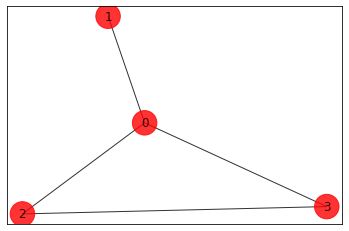

In [ ]:
num_wires = 4  # Number of nodes in graph

elist_clique = [(0, 1), (0, 2), (0, 3), (2, 3)]
colors_clique = ["r" for node in range(num_wires)]

draw_graph(elist_clique, colors_clique)

In [ ]:
adjacency_matrix_clique = get_adjacency_matrix(elist_clique)
clique = Clique(adjacency_matrix_clique)
qp_clique = clique.to_quadratic_program()
print(qp_clique.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Clique

Maximize
 obj: x_0 + x_1 + x_2 + x_3
Subject To
 c0: x_1 + x_2 <= 1
 c1: x_1 + x_3 <= 1

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [ ]:
qp2qubo = QuadraticProgramToQubo()
qubo_clique = qp2qubo.convert(qp_clique)

qubitOp_clique, offset_clique = qubo_clique.to_ising()
H_clique = hamiltonian_from_qiskit(qubitOp_clique)
H_clique_lcu = hamiltonian_from_qiskit_lcu(qubitOp_clique)

print("Offset:", offset_clique,"\n")
print("Ising Hamiltonian:\n")

print(H_clique)

Offset: 0.5 

Ising Hamiltonian:

  (-2.0) [Z1]
+ (-0.75) [Z3]
+ (-0.75) [Z2]
+ (0.5) [Z0]
+ (1.25) [Z1 Z3]
+ (1.25) [Z1 Z2]


## Binary Linear Programming

In [ ]:
blp = Model("docplex model")
x1 = blp.binary_var("x1")
x2 = blp.binary_var("x2")
x3 = blp.binary_var("x3")
x4 = blp.binary_var("x4")

blp.minimize(195000*x1 + 96000*x2 + 87000*x3 + 120000*x4)
blp.add_constraint(x1  + x3 >= 1)
blp.add_constraint(x2 + x4 >= 1)

# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 195000 x1 + 96000 x2 + 87000 x3 + 120000 x4
Subject To
 c0: x1 + x3 >= 1
 c1: x2 + x4 >= 1

Bounds
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x1 x2 x3 x4
End



In [ ]:
qubo_blp = qp2qubo.convert(qp_blp)

qubitOp_blp, offset_blp = qubo_blp.to_ising()
H_blp = hamiltonian_from_qiskit(qubitOp_blp)
H_blp_lcu = hamiltonian_from_qiskit_lcu(qubitOp_blp)

print("Offset:", offset_blp,"\n")
print("Ising Hamiltonian:\n")

print(H_blp)

Offset: 498000.5 

Ising Hamiltonian:

  (27000.25) [Z0]
+ (64500.25) [Z3]
+ (76500.25) [Z1]
+ (81000.25) [Z2]
+ (124500.25) [Z1 Z3]
+ (124500.25) [Z0 Z2]


## Knapsack

In [ ]:
weights = [1, 2]
profits = [2, 1]
max_weight = 3
knapsack = Knapsack(profits, weights, max_weight)
qp_ks = knapsack.to_quadratic_program()
print(qp_ks.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 2 x_0 + x_1
Subject To
 c0: x_0 + 2 x_1 <= 3

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1

Binaries
 x_0 x_1
End



In [ ]:
qubo_ks = qp2qubo.convert(qp_ks)

qubitOp_ks, offset_ks = qubo_ks.to_ising()
H_ks = hamiltonian_from_qiskit(qubitOp_ks)
H_ks_lcu = hamiltonian_from_qiskit_lcu(qubitOp_ks)

print("Offset:", offset_ks,"\n")
print("Ising Hamiltonian:\n")

print(H_ks)

Offset: 8.5 

Ising Hamiltonian:

  (0.5) [Z1]
+ (1.0) [Z0]
+ (2.0) [Z0 Z2]
+ (4.0) [Z2 Z3]
+ (4.0) [Z1 Z2]
+ (4.0) [Z0 Z3]
+ (4.0) [Z0 Z1]
+ (8.0) [Z1 Z3]


# **Optimization**

## Discrete-variable

In [ ]:
# guesting ansatz state

ansatz_label = ['H', 'RX', 'RY', 'RZ'] 

def ansatz(var, num_wires):
    for wire in range(num_wires):
      qml.Hadamard(wires=wire)
      qml.RX(var[0+3*wire], wires=wire)
      qml.RY(var[1+3*wire], wires=wire)
      qml.RZ(var[2+3*wire], wires=wire)
    fully_connected_layer(num_wires)

In [ ]:
def cost_function(var, H, device="default.qubit", backend=None, ibmqx_token=None):
  num_wires = len(H.wires)

  if device=="default.qubit":
    dev = qml.device(device, wires=num_wires, shots=1024)
  else:
    dev = qml.device(device, backend=backend, wires=num_wires, ibmqx_token=ibmqx_token, shots=1024)
  @qml.qnode(dev)
  def circuit(var, H):
    for v in var: 
      ansatz(v, num_wires)
    return qml.expval(H)

  return circuit(var, H)

Probability distribution of estimated gate 

In [ ]:
# prediction circuit
def prediction(var, num_param_gates, device="default.qubit", backend=None, ibmqx_token=None):
  num_wires = len(var[0])//num_param_gates

  if device=="default.qubit":
    dev = qml.device(device, wires=num_wires, shots=1024)
  else:
    dev = qml.device(device, backend=backend, wires=num_wires, ibmqx_token=ibmqx_token, shots=1024)
  @qml.qnode(dev)
  def circuit(var):
    for v in var: 
      ansatz(v, num_wires)
    return qml.probs(wires=range(num_wires))  # get prediction probability
  
  state = circuit(var)
  result = np.argmax(state)
  return int_to_binary(result, num_wires)[::-1]

In [ ]:
np.random.seed(1)
num_layers = 2
num_param_gates = 3

var_init_maxcut = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
var_init_clique = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))
var_init_blp = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))
var_init_ks = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

steps = [2, 4, 6, 8, 10]

In [ ]:
print("Initial cost: ", cost_function(var_init_maxcut, H_maxcut)+offset_maxcut)

Initial cost:  -1.740234375


In [ ]:
print("Prediction: ", prediction(var_init_maxcut, num_param_gates))

Prediction:  0000


Function for training optimizer

In [ ]:
def train(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  time_list = []

  var = var_init.copy()

  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost)

      if it%10==0:
        print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
      time_list.append(t)

  return lost_list, time_list, var

Varaible List

In [ ]:
# lost list
psl = []
fdl = []
lcul = []
qngl = []
qnwl = []

# time list
pst = []
fdt = []
lcut = []
qngt = []
qnwt = []


# lost list change num layer
pslc = []
fdlc = []
lculc = []
qnglc = []
qnwlc = []

# time list change num layer
pstc = []
fdtc = []
lcutc = []
qngtc = []
qnwtc = []

### Parameter Shift Rule

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_maxcut), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: -1.67187500000 
Iter:    10 | Cost: -2.93261718750 
Iter:    20 | Cost: -3.12988281250 
Iter:    30 | Cost: -3.32714843750 
Iter:    40 | Cost: -3.48632812500 
Iter:    50 | Cost: -3.50292968750 
Iter:    60 | Cost: -3.50000000000 
Iter:    70 | Cost: -3.53125000000 
Iter:    80 | Cost: -3.48339843750 
Iter:    90 | Cost: -3.54003906250 
Iter:   100 | Cost: -3.49316406250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_maxcut), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: -1.68847656250 
Iter:    10 | Cost: -2.93554687500 
Iter:     0 | Cost: -2.89648437500 
Iter:    10 | Cost: -3.83886718750 
Iter:     0 | Cost: -2.51953125000 
Iter:    10 | Cost: -3.93261718750 
Iter:     0 | Cost: -1.93945312500 
Iter:    10 | Cost: -3.95703125000 
Iter:     0 | Cost: -2.35156250000 
Iter:    10 | Cost: -3.82324218750 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_clique), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: 0.10400390625 
Iter:    10 | Cost: -2.11474609375 
Iter:    20 | Cost: -2.33251953125 
Iter:    30 | Cost: -2.41894531250 
Iter:    40 | Cost: -2.45410156250 
Iter:    50 | Cost: -2.53173828125 
Iter:    60 | Cost: -2.58789062500 
Iter:    70 | Cost: -2.44384765625 
Iter:    80 | Cost: -2.51074218750 
Iter:    90 | Cost: -2.51757812500 
Iter:   100 | Cost: -2.45361328125 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_clique), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: -0.24316406250 
Iter:    10 | Cost: -1.97412109375 
Iter:     0 | Cost: -0.05957031250 
Iter:    10 | Cost: -1.92187500000 
Iter:     0 | Cost: 0.14990234375 
Iter:    10 | Cost: -2.13574218750 
Iter:     0 | Cost: 0.73876953125 
Iter:    10 | Cost: -1.86669921875 
Iter:     0 | Cost: 0.62744140625 
Iter:    10 | Cost: -2.92773437500 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_blp), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: 667202.15039062500 
Iter:    10 | Cost: 386874.23193359375 
Iter:    20 | Cost: 306506.92089843750 
Iter:    30 | Cost: 265321.37255859375 
Iter:    40 | Cost: 213761.73193359375 
Iter:    50 | Cost: 187675.78027343750 
Iter:    60 | Cost: 184760.74462890625 
Iter:    70 | Cost: 183023.43750000000 
Iter:    80 | Cost: 183108.39794921875 
Iter:    90 | Cost: 183752.93115234375 
Iter:   100 | Cost: 183518.55566406250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_blp), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: 636012.69189453125 
Iter:    10 | Cost: 321413.24169921875 
Iter:     0 | Cost: 580532.90380859375 
Iter:    10 | Cost: 201996.10107421875 
Iter:     0 | Cost: 529954.78515625000 
Iter:    10 | Cost: 217277.34228515625 
Iter:     0 | Cost: 483823.72753906250 
Iter:    10 | Cost: 216076.18310546875 
Iter:     0 | Cost: 450354.91943359375 
Iter:    10 | Cost: 220731.46923828125 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_ks), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: 27.63867187500 
Iter:    10 | Cost: 5.21191406250 
Iter:    20 | Cost: 3.44531250000 
Iter:    30 | Cost: 0.56933593750 
Iter:    40 | Cost: -1.41503906250 
Iter:    50 | Cost: -2.54492187500 
Iter:    60 | Cost: -3.03125000000 
Iter:    70 | Cost: -3.00585937500 
Iter:    80 | Cost: -2.99414062500 
Iter:    90 | Cost: -2.98242187500 
Iter:   100 | Cost: -2.98632812500 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_ks), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: 16.14941406250 
Iter:    10 | Cost: 2.64648437500 
Iter:     0 | Cost: 15.89941406250 
Iter:    10 | Cost: -0.96679687500 
Iter:     0 | Cost: 6.25390625000 
Iter:    10 | Cost: -1.32910156250 
Iter:     0 | Cost: 10.93750000000 
Iter:    10 | Cost: -2.37304687500 
Iter:     0 | Cost: 14.15039062500 
Iter:    10 | Cost: -1.60449218750 


### Finite Difference

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_maxcut), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: -1.70312500000 
Iter:    10 | Cost: -1.91699218750 
Iter:    20 | Cost: -1.91796875000 
Iter:    30 | Cost: -2.24316406250 
Iter:    40 | Cost: -2.38574218750 
Iter:    50 | Cost: -2.36718750000 
Iter:    60 | Cost: -2.36230468750 
Iter:    70 | Cost: -2.51074218750 
Iter:    80 | Cost: -2.54589843750 
Iter:    90 | Cost: -2.46289062500 
Iter:   100 | Cost: -2.51757812500 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_maxcut), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: -1.68847656250 
Iter:    10 | Cost: -1.97753906250 
Iter:     0 | Cost: -2.89648437500 
Iter:    10 | Cost: -3.03027343750 
Iter:     0 | Cost: -2.51953125000 
Iter:    10 | Cost: -2.83007812500 
Iter:     0 | Cost: -1.93945312500 
Iter:    10 | Cost: -2.50683593750 
Iter:     0 | Cost: -2.35156250000 
Iter:    10 | Cost: -2.75097656250 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_clique), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: 0.10400390625 
Iter:    10 | Cost: -0.36718750000 
Iter:    20 | Cost: -0.64013671875 
Iter:    30 | Cost: -0.58740234375 
Iter:    40 | Cost: -1.00146484375 
Iter:    50 | Cost: -1.16992187500 
Iter:    60 | Cost: -1.59375000000 
Iter:    70 | Cost: -1.58105468750 
Iter:    80 | Cost: -1.94238281250 
Iter:    90 | Cost: -1.90527343750 
Iter:   100 | Cost: -1.79052734375 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_clique), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: -0.24316406250 
Iter:    10 | Cost: -0.27880859375 
Iter:     0 | Cost: -0.05957031250 
Iter:    10 | Cost: -0.24023437500 
Iter:     0 | Cost: 0.14990234375 
Iter:    10 | Cost: -0.93652343750 
Iter:     0 | Cost: 0.73876953125 
Iter:    10 | Cost: -0.47509765625 
Iter:     0 | Cost: 0.62744140625 
Iter:    10 | Cost: -0.84619140625 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_blp), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: 667202.15039062500 
Iter:    10 | Cost: 618320.13085937500 
Iter:    20 | Cost: 537003.46679687500 
Iter:    30 | Cost: 533684.12255859375 
Iter:    40 | Cost: 538131.39941406250 
Iter:    50 | Cost: 509165.46386718750 
Iter:    60 | Cost: 491587.30029296875 
Iter:    70 | Cost: 446968.02197265625 
Iter:    80 | Cost: 404616.34277343750 
Iter:    90 | Cost: 393506.92382812500 
Iter:   100 | Cost: 399255.01513671875 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_blp), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: 636012.69189453125 
Iter:    10 | Cost: 538486.00439453125 
Iter:     0 | Cost: 580532.90380859375 
Iter:    10 | Cost: 429184.94628906250 
Iter:     0 | Cost: 529954.78515625000 
Iter:    10 | Cost: 434165.44824218750 
Iter:     0 | Cost: 483823.72753906250 
Iter:    10 | Cost: 443358.69677734375 
Iter:     0 | Cost: 450354.91943359375 
Iter:    10 | Cost: 373224.80419921875 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_ks), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: 27.63867187500 
Iter:    10 | Cost: 20.09960937500 
Iter:    20 | Cost: 19.12890625000 
Iter:    30 | Cost: 12.71679687500 
Iter:    40 | Cost: 9.85058593750 
Iter:    50 | Cost: 8.40527343750 
Iter:    60 | Cost: 7.40820312500 
Iter:    70 | Cost: 7.14648437500 
Iter:    80 | Cost: 6.17968750000 
Iter:    90 | Cost: 6.57812500000 
Iter:   100 | Cost: 4.95019531250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_ks), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: 16.14941406250 
Iter:    10 | Cost: 9.73144531250 
Iter:     0 | Cost: 15.89941406250 
Iter:    10 | Cost: 10.77050781250 
Iter:     0 | Cost: 6.25390625000 
Iter:    10 | Cost: 6.70800781250 
Iter:     0 | Cost: 10.93750000000 
Iter:    10 | Cost: 3.61816406250 
Iter:     0 | Cost: 14.15039062500 
Iter:    10 | Cost: 3.52343750000 


### Linear combination of unitaries (LCU)

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: lcu_gradients(ansatz_label, H_maxcut_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: -1.73632812500 
Iter:    10 | Cost: -2.89257812500 
Iter:    20 | Cost: -3.12695312500 
Iter:    30 | Cost: -3.28320312500 
Iter:    40 | Cost: -3.46191406250 
Iter:    50 | Cost: -3.47265625000 
Iter:    60 | Cost: -3.54687500000 
Iter:    70 | Cost: -3.49121093750 
Iter:    80 | Cost: -3.47949218750 
Iter:    90 | Cost: -3.45800781250 
Iter:   100 | Cost: -3.46777343750 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_maxcut_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: -1.72753906250 
Iter:    10 | Cost: -2.94238281250 
Iter:     0 | Cost: -1.59667968750 
Iter:    10 | Cost: -3.47949218750 
Iter:     0 | Cost: -2.60351562500 
Iter:    10 | Cost: -3.93554687500 
Iter:     0 | Cost: -2.27441406250 
Iter:    10 | Cost: -3.96386718750 
Iter:     0 | Cost: -2.16503906250 
Iter:    10 | Cost: -3.73925781250 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: lcu_gradients(ansatz_label, H_clique_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: 0.12597656250 
Iter:    10 | Cost: -1.99462890625 
Iter:    20 | Cost: -2.21582031250 
Iter:    30 | Cost: -2.40576171875 
Iter:    40 | Cost: -2.43261718750 
Iter:    50 | Cost: -2.40966796875 
Iter:    60 | Cost: -2.47070312500 
Iter:    70 | Cost: -2.51953125000 
Iter:    80 | Cost: -2.51757812500 
Iter:    90 | Cost: -2.51708984375 
Iter:   100 | Cost: -2.53564453125 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_clique_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: -0.30566406250 
Iter:    10 | Cost: -1.87011718750 
Iter:     0 | Cost: 0.75781250000 
Iter:    10 | Cost: -2.64355468750 
Iter:     0 | Cost: -0.42480468750 
Iter:    10 | Cost: -2.56982421875 
Iter:     0 | Cost: -0.12158203125 
Iter:    10 | Cost: -2.75830078125 
Iter:     0 | Cost: 0.72021484375 
Iter:    10 | Cost: -2.69433593750 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: lcu_gradients(ansatz_label, H_blp_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: 666809.57470703125 
Iter:    10 | Cost: 381647.65576171875 
Iter:    20 | Cost: 312753.00390625000 
Iter:    30 | Cost: 263698.29101562500 
Iter:    40 | Cost: 217330.09228515625 
Iter:    50 | Cost: 192041.01562500000 
Iter:    60 | Cost: 188340.83251953125 
Iter:    70 | Cost: 184734.37695312500 
Iter:    80 | Cost: 183726.56201171875 
Iter:    90 | Cost: 183802.73632812500 
Iter:   100 | Cost: 184620.12207031250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_blp_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: 625556.61230468750 
Iter:    10 | Cost: 312694.47412109375 
Iter:     0 | Cost: 572127.64648437500 
Iter:    10 | Cost: 300178.73095703125 
Iter:     0 | Cost: 397046.12841796875 
Iter:    10 | Cost: 226869.15625000000 
Iter:     0 | Cost: 481945.73242187500 
Iter:    10 | Cost: 207172.87255859375 
Iter:     0 | Cost: 510835.49902343750 
Iter:    10 | Cost: 200586.91015625000 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: lcu_gradients(ansatz_label, H_ks_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: 27.49121093750 
Iter:    10 | Cost: 5.92773437500 
Iter:    20 | Cost: 3.05468750000 
Iter:    30 | Cost: 1.68945312500 
Iter:    40 | Cost: -1.38867187500 
Iter:    50 | Cost: -2.64843750000 
Iter:    60 | Cost: -2.91992187500 
Iter:    70 | Cost: -3.02832031250 
Iter:    80 | Cost: -2.95898437500 
Iter:    90 | Cost: -3.00488281250 
Iter:   100 | Cost: -3.02441406250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_ks_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: 15.89160156250 
Iter:    10 | Cost: 2.38085937500 
Iter:     0 | Cost: 12.92480468750 
Iter:    10 | Cost: -0.25878906250 
Iter:     0 | Cost: 9.74609375000 
Iter:    10 | Cost: -2.36132812500 
Iter:     0 | Cost: 6.12988281250 
Iter:    10 | Cost: -0.32617187500 
Iter:     0 | Cost: 12.19628906250 
Iter:    10 | Cost: -1.76855468750 


### Quantum natural gradient (QNG)

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: quantum_natural_gradient(var, H_maxcut, lambda x: cost_function(x, H_maxcut))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: -1.71484375000 
Iter:    10 | Cost: -2.94238281250 
Iter:    20 | Cost: -3.15332031250 
Iter:    30 | Cost: -3.41308593750 
Iter:    40 | Cost: -3.51464843750 
Iter:    50 | Cost: -3.53710937500 
Iter:    60 | Cost: -3.51171875000 
Iter:    70 | Cost: -3.54296875000 
Iter:    80 | Cost: -3.54296875000 
Iter:    90 | Cost: -3.50390625000 
Iter:   100 | Cost: -3.47167968750 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: quantum_natural_gradient(var, H_maxcut, lambda x: cost_function(x, H_maxcut))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: -1.68847656250 
Iter:    10 | Cost: -2.94628906250 
Iter:     0 | Cost: -2.89648437500 
Iter:    10 | Cost: -3.85156250000 
Iter:     0 | Cost: -2.51953125000 
Iter:    10 | Cost: -3.92968750000 
Iter:     0 | Cost: -1.93945312500 
Iter:    10 | Cost: -3.92871093750 
Iter:     0 | Cost: -2.35156250000 
Iter:    10 | Cost: -3.81933593750 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: quantum_natural_gradient(var, H_clique, lambda x: cost_function(x, H_clique))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: 0.10400390625 
Iter:    10 | Cost: -2.19482421875 
Iter:    20 | Cost: -2.37792968750 
Iter:    30 | Cost: -2.43603515625 
Iter:    40 | Cost: -2.44433593750 
Iter:    50 | Cost: -2.53466796875 
Iter:    60 | Cost: -2.58203125000 
Iter:    70 | Cost: -2.44384765625 
Iter:    80 | Cost: -2.50195312500 
Iter:    90 | Cost: -2.51562500000 
Iter:   100 | Cost: -2.45800781250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: quantum_natural_gradient(var, H_clique, lambda x: cost_function(x, H_clique))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: -0.24316406250 
Iter:    10 | Cost: -1.99267578125 
Iter:     0 | Cost: -0.05957031250 
Iter:    10 | Cost: -1.92187500000 
Iter:     0 | Cost: 0.14990234375 
Iter:    10 | Cost: -2.32861328125 
Iter:     0 | Cost: 0.73876953125 
Iter:    10 | Cost: -1.96337890625 
Iter:     0 | Cost: 0.62744140625 
Iter:    10 | Cost: -2.88867187500 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: quantum_natural_gradient(var, H_blp, lambda x: cost_function(x, H_blp))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: 667202.15039062500 
Iter:    10 | Cost: 384902.54736328125 
Iter:    20 | Cost: 305112.38769531250 
Iter:    30 | Cost: 268013.75976562500 
Iter:    40 | Cost: 213073.24951171875 
Iter:    50 | Cost: 189899.41601562500 
Iter:    60 | Cost: 184760.74462890625 
Iter:    70 | Cost: 183023.43750000000 
Iter:    80 | Cost: 183108.39794921875 
Iter:    90 | Cost: 183752.93115234375 
Iter:   100 | Cost: 183518.55566406250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: quantum_natural_gradient(var, H_blp, lambda x: cost_function(x, H_blp))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: 636012.69189453125 
Iter:    10 | Cost: 315073.38427734375 
Iter:     0 | Cost: 580532.90380859375 
Iter:    10 | Cost: 201386.72460937500 
Iter:     0 | Cost: 529954.78515625000 
Iter:    10 | Cost: 215575.19384765625 
Iter:     0 | Cost: 483823.72753906250 
Iter:    10 | Cost: 216776.38378906250 
Iter:     0 | Cost: 450354.91943359375 
Iter:    10 | Cost: 206314.44921875000 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: quantum_natural_gradient(var, H_ks, lambda x: cost_function(x, H_ks))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: 27.63867187500 
Iter:    10 | Cost: 5.16406250000 
Iter:    20 | Cost: 3.51660156250 
Iter:    30 | Cost: 1.55468750000 
Iter:    40 | Cost: -1.30566406250 
Iter:    50 | Cost: -2.45019531250 
Iter:    60 | Cost: -3.00000000000 
Iter:    70 | Cost: -3.00390625000 
Iter:    80 | Cost: -2.99414062500 
Iter:    90 | Cost: -2.95898437500 
Iter:   100 | Cost: -2.98535156250 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: quantum_natural_gradient(var, H_ks, lambda x: cost_function(x, H_ks))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: 16.14941406250 
Iter:    10 | Cost: 2.27050781250 
Iter:     0 | Cost: 15.89941406250 
Iter:    10 | Cost: -1.02050781250 
Iter:     0 | Cost: 6.25390625000 
Iter:    10 | Cost: -1.74414062500 
Iter:     0 | Cost: 10.93750000000 
Iter:    10 | Cost: -2.29492187500 
Iter:     0 | Cost: 14.15039062500 
Iter:    10 | Cost: -1.92285156250 


### Quantum newton gradient

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: newton_gradient(cost_function, H_maxcut, var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: -1.70312500000 
Iter:    10 | Cost: -2.92382812500 
Iter:    20 | Cost: -3.31152343750 
Iter:    30 | Cost: -3.46972656250 
Iter:    40 | Cost: -3.47460937500 
Iter:    50 | Cost: -3.46777343750 
Iter:    60 | Cost: -3.54589843750 
Iter:    70 | Cost: -3.49316406250 
Iter:    80 | Cost: -3.57324218750 
Iter:    90 | Cost: -3.50878906250 
Iter:   100 | Cost: -3.47070312500 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: newton_gradient(cost_function, H_maxcut, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: -1.68847656250 
Iter:    10 | Cost: -2.99121093750 
Iter:     0 | Cost: -2.89648437500 
Iter:    10 | Cost: -3.87402343750 
Iter:     0 | Cost: -2.51953125000 
Iter:    10 | Cost: -3.76562500000 
Iter:     0 | Cost: -1.93945312500 
Iter:    10 | Cost: -3.80468750000 
Iter:     0 | Cost: -2.35156250000 
Iter:    10 | Cost: -3.76855468750 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: newton_gradient(cost_function,H_clique, var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: 0.10400390625 
Iter:    10 | Cost: -1.73730468750 
Iter:    20 | Cost: -2.14306640625 
Iter:    30 | Cost: -2.34521484375 
Iter:    40 | Cost: -2.44042968750 
Iter:    50 | Cost: -2.54492187500 
Iter:    60 | Cost: -2.60839843750 
Iter:    70 | Cost: -2.45019531250 
Iter:    80 | Cost: -2.73242187500 
Iter:    90 | Cost: -2.94140625000 
Iter:   100 | Cost: -2.99462890625 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: newton_gradient(cost_function, H_clique, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: -0.24316406250 
Iter:    10 | Cost: -1.95410156250 
Iter:     0 | Cost: -0.05957031250 
Iter:    10 | Cost: -0.18212890625 
Iter:     0 | Cost: 0.14990234375 
Iter:    10 | Cost: -1.60791015625 
Iter:     0 | Cost: 0.73876953125 
Iter:    10 | Cost: -1.54687500000 
Iter:     0 | Cost: 0.62744140625 
Iter:    10 | Cost: -1.26953125000 


#### Binary Linear Programming

In [ ]:
lr = 1
epochs = 101
reg = 3.0
cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: newton_gradient(cost_function,H_blp, var, reg)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: 667202.15039062500 
Iter:    10 | Cost: 539631.42041015625 
Iter:    20 | Cost: 474855.93896484375 
Iter:    30 | Cost: 496090.38378906250 
Iter:    40 | Cost: 518728.09716796875 
Iter:    50 | Cost: 552911.76367187500 
Iter:    60 | Cost: 517564.87353515625 
Iter:    70 | Cost: 431156.31884765625 
Iter:    80 | Cost: 591733.22119140625 
Iter:    90 | Cost: 602033.70019531250 
Iter:   100 | Cost: 506042.58105468750 


In [ ]:
lr = 1
epochs = 11
reg = 3.0
np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: newton_gradient(cost_function, H_blp, var, reg)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(min(lost_list))
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: 636012.69189453125 
Iter:    10 | Cost: 692579.15673828125 
Iter:     0 | Cost: 580532.90380859375 
Iter:    10 | Cost: 583556.28808593750 
Iter:     0 | Cost: 529954.78515625000 
Iter:    10 | Cost: 495888.23388671875 
Iter:     0 | Cost: 483823.72753906250 
Iter:    10 | Cost: 441770.81689453125 
Iter:     0 | Cost: 450354.91943359375 
Iter:    10 | Cost: 448512.16992187500 


#### Knapsack

In [ ]:
lr = 1
epochs = 101
reg = 3.2
cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: newton_gradient(cost_function,H_ks, var, reg)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: 27.63867187500 
Iter:    10 | Cost: 2.70996093750 
Iter:    20 | Cost: 2.54687500000 
Iter:    30 | Cost: -2.44921875000 
Iter:    40 | Cost: -0.95703125000 
Iter:    50 | Cost: 0.06835937500 
Iter:    60 | Cost: -2.94531250000 
Iter:    70 | Cost: -1.92871093750 
Iter:    80 | Cost: 5.92187500000 
Iter:    90 | Cost: -2.95898437500 
Iter:   100 | Cost: -2.77441406250 


In [ ]:
lr = 1
epochs = 11
reg = 3.2
np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: newton_gradient(cost_function, H_ks, var, reg)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: 16.14941406250 
Iter:    10 | Cost: 2.45605468750 
Iter:     0 | Cost: 15.89941406250 
Iter:    10 | Cost: 5.67480468750 
Iter:     0 | Cost: 6.25390625000 
Iter:    10 | Cost: 5.39941406250 
Iter:     0 | Cost: 10.93750000000 
Iter:    10 | Cost: 1.36328125000 
Iter:     0 | Cost: 14.15039062500 
Iter:    10 | Cost: 5.96875000000 


#**Benchmarking** 

### Contour Plot

In [ ]:
#@title Train Contour
def train_contour(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  var_list = []
  var = var_init.copy()
  var_list.append(var)
  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost.numpy())
      var_list.append(var)
      # if it%10==0:
      #   print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
  return lost_list, var_list


def quantum_natural_gradient_contour(var, H, cost_function):
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def metric_tensor_circuit(var):
    for v in var: 
      ansatz_contour(v)
    return qml.expval(H)

  metric_fn = qml.metric_tensor(metric_tensor_circuit, approx="block-diag", hybrid=False)
  grad = parameter_shift(cost_function, var)
  grad_flatten = grad.flatten()
  metric_tensor = metric_fn(var)
  try:
    qng_grad = np.linalg.solve(metric_tensor, grad_flatten)
  except: 
    qng_grad = np.linalg.lstsq(metric_tensor, grad_flatten, rcond=None)[0]
  return qng_grad


param_gates = ['RX', 'RY', 'RZ']

def lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers):
  qml.Hadamard(wires=num_wires)
  break_point = len(ansatz)//num_layers
  qml.adjoint(qml.S)(wires=num_wires)

  counting = 0
  for i, gate in enumerate(ansatz):
    
    if gate in param_gates:
      if i == diff_index:
        controlStr(gate)(wires=[num_wires, diff_index//2])
      str2gate(gate)(params[counting], wires=wires[i])
      counting += 1
    else:
      str2gate(gate)(wires=wires[i])
    if i!=0 and (i+1)%break_point==0:
      fully_connected_layer(num_wires)
  qml.Hadamard(wires=num_wires)

def lcu_gradients_contour(ansatz_label, H, params):
  num_layers = len(params)
  num_wires = len(H.wires)-1
  num_param_gates = len(params[0])//num_wires

  ansatz = ansatz_label * num_layers * num_wires
  
  wires = []
  for i in range(num_layers):
    for j in range(num_wires):
      for k in range(2):
        wires.append(j)
  params = params.flatten()

  dev = qml.device("default.qubit", wires=num_wires+1)
  @qml.qnode(dev)
  def lcu(ansatz, H, params, wires, diff_index):
    
    lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers)
    
    return qml.expval(H)

  gradients = []
  for i in range(len(ansatz)):
    if ansatz[i] in param_gates:
      gradients.append(lcu(ansatz, H, params, wires, i))
      
  return np.array(gradients).reshape(num_layers, -1)

def newton_gradient_contour(H, params, reg):
  num_layers = len(params)
  params = params.reshape(1,-1)[0]
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def circuit(var,H):
    qml.RX(var[0], wires=0)
    qml.RZ(var[1], wires=0)
    return qml.expval(H)

  grad_fn = qml.grad(circuit)
  hes_fn = qml.jacobian(grad_fn)
  grad = grad_fn(params, H)
  hessian_matrix = hes_fn(params, H)
  iden = np.identity(len(hessian_matrix))*reg
  hessian_matrix += iden
  
  try:
    #x = np.linalg.inv(hessian_matrix)
    newton_grad = np.linalg.solve(hessian_matrix, grad)
  except: 
    #x = np.linalg.pinv(hessian_matrix)
    newton_grad = np.linalg.lstsq(hessian_matrix, grad, rcond=None)[0] 
  
  return newton_grad.reshape(num_layers,-1)

In [ ]:
#@title Gradient Plot
blp = Model("docplex model")
x1 = blp.binary_var("x1")

blp.minimize(95000*x1)
blp.add_constraint(x1 >= 1)
# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())
qubo_blp = qp2qubo.convert(qp_blp) 
qubitOp_blp, offset_contour = qubo_blp.to_ising()

qubitOp_blp += 0.5*I
H_contour_lcu = qml.Hamiltonian([0.5, 0.0], [qml.PauliZ(0)@qml.PauliZ(1), qml.Identity(0)])
H_contour = hamiltonian_from_qiskit(qubitOp_blp)

from tqdm.notebook import tqdm
# objective function
def ansatz_contour(var):
    qml.RX(var[0], wires=0)
    qml.RZ(var[1], wires=0)
    
def cost_function_contour(var, H):
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def circuit(var, H):
    ansatz_contour(var[0])
    return qml.expval(H)

  return circuit(var, H)

X = np.linspace(-8, 8, 50)
Y = np.linspace(-8, 8, 50)
X_m, Y_m = np.meshgrid(X, Y)
Z = np.zeros((50, 50))
for i in tqdm(range(50)):
  for j in range(50):
    var = np.array([[X_m[i, j], Y_m[i, j]]])
    Z[i, j] = cost_function_contour(var, H_contour)

lr = 0.03
epochs = 201
var_contour = np.array([[0.8163265, 0.8163265+1]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: parameter_shift(lambda x: cost_function_contour(x, H_contour), var)
lost_list_ps, var_list_ps = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[0.8163265, 0.8163265+0.5]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: finite_difference(lambda x: cost_function_contour(x, H_contour), var)
lost_list_fd, var_list_fd = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[0.8163265, 0.8163265]])
ansatz_label = ["RX", "RZ"]
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: lcu_gradients_contour(ansatz_label, H_contour_lcu, var)
lost_list_lcu, var_list_lcu = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[0.8163265, 0.8163265-0.5]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: quantum_natural_gradient_contour(var, H_contour, lambda x: cost_function_contour(x, H_contour))
lost_list_qng, var_list_qng = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

lr = 1
reg = 1.0
var_contour = np.array([[0.8163265, 0.8163265-1.0]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: newton_gradient_contour(H_contour, var, reg)
lost_list_qnw, var_list_qnw = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)


a_ps = []
b_ps = []
for var in var_list_ps:
  a_ps.append(var[0][0]+0.1)
  b_ps.append(var[0][1])
c_ps = [v-offset_contour for v in lost_list_ps]

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, showscale=False)])
fig.add_trace(go.Scatter3d(x=a_ps, y=b_ps,z=c_ps, mode='lines',
                           line=dict(
                              color='yellow',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_ps[0]], y=[b_ps[0]],z=[c_ps[0]], marker=dict(
        size=7,
        color="yellow"
    ), name="Parameter Shift Rule" ))


a_fd = []
b_fd = []
for var in var_list_fd:
  a_fd.append(var[0][0]+0.1)
  b_fd.append(var[0][1])
c_fd = [v-offset_contour for v in lost_list_fd]
fig.add_trace(go.Scatter3d(x=a_fd, y=b_fd,z=c_fd, mode='lines',
                           line=dict(
                              color='blue',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_fd[0]], y=[b_fd[0]],z=[c_fd[0]], marker=dict(
        size=7,
        color="blue"
    ), name="Finite Difference" ))

a_lcu = []
b_lcu = []
for var in var_list_lcu:
  a_lcu.append(var[0][0]+0.1)
  b_lcu.append(var[0][1])
c_lcu = [v-offset_contour for v in lost_list_lcu]
fig.add_trace(go.Scatter3d(x=a_lcu, y=b_lcu,z=c_lcu, mode='lines',
                           line=dict(
                              color='red',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_lcu[0]], y=[b_lcu[0]],z=[c_lcu[0]], marker=dict(
        size=7,
        color="red"
    ), name="Linear Combination of Unitaries" ))


a_qng = []
b_qng = []
for var in var_list_qng:
  a_qng.append(var[0][0]+0.1)
  b_qng.append(var[0][1])
c_qng = [v-offset_contour for v in lost_list_qng]
fig.add_trace(go.Scatter3d(x=a_qng, y=b_qng,z=c_qng, mode='lines',
                           line=dict(
                              color='purple',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_qng[0]], y=[b_qng[0]],z=[c_qng[0]], marker=dict(
        size=7,
        color="purple"
    ), name="Quantum Natural Gradient" ))

a_qnw = []
b_qnw = []
for var in var_list_qnw:
  a_qnw.append(var[0][0]+0.1)
  b_qnw.append(var[0][1])
c_qnw = [v-offset_contour for v in lost_list_qnw]
fig.add_trace(go.Scatter3d(x=a_qnw, y=b_qnw,z=c_qnw, mode='lines',
                           line=dict(
                              color='black',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_qnw[0]], y=[b_qnw[0]],z=[c_qnw[0]], marker=dict(
        size=7,
        color="black"
    ), name="Quantum Newton Gradient" ))

for trace in fig['data']: 
    if(trace['name'] is None): trace['showlegend'] = False


fig.update_layout(title='Max-Cut Cost Funtion', autosize=False,
    width=1000,
    height=1000)

fig.show()


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 95000 x1
Subject To
 c0: x1 >= 1

Bounds
 0 <= x1 <= 1

Binaries
 x1
End



  0%|          | 0/50 [00:00<?, ?it/s]

## Fixed the number of gate

In [ ]:
#@title Loss Comparison 
#@markdown Fixed the number of parameterized gate (6 gate).
from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"Iteration":range(len(psl[problemn])), "Loss":psl[problemn]})
    dv_fd = pd.DataFrame({"Iteration":range(len(fdl[problemn])), "Loss":fdl[problemn]})
    dv_lcu = pd.DataFrame({"Iteration":range(len(lcul[problemn])), "Loss":lcul[problemn]})
    dv_qng = pd.DataFrame({"Iteration":range(len(qngl[problemn])), "Loss":qngl[problemn]})
    dv_newton = pd.DataFrame({"Iteration":range(len(qnwl[problemn])), "Loss":qnwl[problemn]})

    # dv_cls = pd.DataFrame({"Iteration":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["Iteration"], y=dv["Loss"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["Iteration"], y=dv_fd["Loss"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["Iteration"], y=dv_lcu["Loss"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["Iteration"], y=dv_qng["Loss"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["Iteration"], y=dv_newton["Loss"], mode="lines", name="Discrete Newton Gradient", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["Iteration"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Loss Comparison  <br><sup>Fixed the number of parameterized gate (6 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)

plotly.offline.plot(fig, filename='loss_fixgate.html')
fig.show()

In [ ]:
import pickle

with open('sampling_psl.pk', 'wb') as fp:
    pickle.dump(psl, fp)
with open('sampling_fdl.pk', 'wb') as fp:
    pickle.dump(fdl, fp)
with open('sampling_lcul.pk', 'wb') as fp:
    pickle.dump(lcul, fp)
with open('sampling_qngl.pk', 'wb') as fp:
    pickle.dump(qngl, fp)
with open('sampling_qnwl.pk', 'wb') as fp:
    pickle.dump(qnwl, fp)

In [ ]:
#@title Time Comparison
#@markdown Fixed the number of parameterized gate (6 gate).

from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"Iteration":range(len(pst[problemn])), "Time":pst[problemn]})
    dv_fd = pd.DataFrame({"Iteration":range(len(fdt[problemn])), "Time":fdt[problemn]})
    dv_lcu = pd.DataFrame({"Iteration":range(len(lcut[problemn])), "Time":lcut[problemn]})
    dv_qng = pd.DataFrame({"Iteration":range(len(qngt[problemn])), "Time":qngt[problemn]})
    dv_newton = pd.DataFrame({"Iteration":range(len(qnwt[problemn])), "Time":qnwt[problemn]})

    # dv_cls = pd.DataFrame({"Iteration":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["Iteration"], y=dv["Time"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["Iteration"], y=dv_fd["Time"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["Iteration"], y=dv_lcu["Time"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["Iteration"], y=dv_qng["Time"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["Iteration"], y=dv_newton["Time"], mode="lines", name="Discrete Newton Method", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["Iteration"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Time Comparison  <br><sup>Fixed the number of parameterized gate (6 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixgate.html')
fig.show()

In [ ]:
with open('sampling_pst.pk', 'wb') as fp:
    pickle.dump(pst, fp)
with open('sampling_fdt.pk', 'wb') as fp:
    pickle.dump(fdt, fp)
with open('sampling_lcut.pk', 'wb') as fp:
    pickle.dump(lcut, fp)
with open('sampling_qngt.pk', 'wb') as fp:
    pickle.dump(qngt, fp)
with open('sampling_qnwt.pk', 'wb') as fp:
    pickle.dump(qnwt, fp)

In [ ]:
#@title Comparison Table
rows = ['Discrete Parameter Shift',
          'Discrete Finite Difference',
          'Discrete LCU', 
          'Discrete QNG',
          'Discrete Newton Gradient',
          #'Classical'
          ]
columns_g = ["Iteration 25", "Iteration 50", "Iteration 75", "Iteration 100"]
iters = [25, 50, 75, 100]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[psl[problemn][iters[0]], pst[problemn][iters[0]], psl[problemn][iters[1]],pst[problemn][iters[1]],psl[problemn][iters[2]],pst[problemn][iters[2]],psl[problemn][iters[3]],pst[problemn][iters[3]]],
                    [fdl[problemn][iters[0]], fdt[problemn][iters[0]], fdl[problemn][iters[1]], fdt[problemn][iters[1]], fdl[problemn][iters[2]], fdt[problemn][iters[2]], fdl[problemn][iters[3]], fdt[problemn][iters[3]]],
                    [lcul[problemn][iters[0]], lcut[problemn][iters[0]], lcul[problemn][iters[1]], lcut[problemn][iters[1]], lcul[problemn][iters[2]], lcut[problemn][iters[2]], lcul[problemn][iters[3]], lcut[problemn][iters[3]]],
                    [qngl[problemn][iters[0]],qngt[problemn][iters[0]],qngl[problemn][iters[1]],qngt[problemn][iters[1]],qngl[problemn][iters[2]],qngt[problemn][iters[2]], qngl[problemn][iters[3]],qngt[problemn][iters[3]]],
                    [qnwl[problemn][iters[0]],qnwt[problemn][iters[0]],qnwl[problemn][iters[1]],qnwt[problemn][iters[1]],qnwl[problemn][iters[2]],qnwt[problemn][iters[2]],qnwl[problemn][iters[3]],qnwt[problemn][iters[3]]],
                    #[loss_plot_classical[5],classical_time_i[100],loss_plot_classical[200],classical_time_i[200],loss_plot_classical[300],classical_time_i[300], loss_plot_classical[400],classical_time_i[400], loss_plot_classical[500],classical_time_i[500]]
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( 'Iteration 25','Loss')] = df[( 'Iteration 25','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 50','Loss')] = df[( 'Iteration 50','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 75','Loss')] = df[( 'Iteration 75','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 100','Loss')] = df[( 'Iteration 100','Loss')].map('{:.2e}'.format)
  # df[( 'Iteration 500','Loss')] = df[( 'Iteration 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  df_styled = df.round(2)
  display(df_styled)
  print("\n\n\n")

Max-Cut


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift      -3.24e+00        78.64    -3.50e+00   
Discrete Finite Difference    -2.08e+00        47.46    -2.37e+00   
Discrete LCU                  -3.18e+00        33.97    -3.47e+00   
Discrete QNG                  -3.29e+00        56.32    -3.54e+00   
Discrete Newton Gradient      -3.37e+00        69.88    -3.47e+00   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift         131.68    -3.53e+00       183.53   
Discrete Finite Difference        93.43    -2.55e+00       139.04   
Discrete LCU                      67.18    -3.52e+00        99.98   
Discrete QNG                     109.86    -3.51e+00       162.19   
Discrete Newton Gradient         135.31    -3.49e+00       200.82   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift       -3.49e+00       236.42  
Discrete Finite Difference     -2.52e+00       184.19  
Discrete LCU                   -3.47e+00       137.58  
Discrete QNG                   -3.47e+00       213.97  
Discrete Newton Gradient       -3.47e+00       266.40





Clique


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift      -2.37e+00        57.52    -2.53e+00   
Discrete Finite Difference    -5.24e-01        54.94    -1.17e+00   
Discrete LCU                  -2.36e+00        41.14    -2.41e+00   
Discrete QNG                  -2.40e+00        59.22    -2.53e+00   
Discrete Newton Gradient      -2.26e+00        76.17    -2.54e+00   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift         123.91    -2.44e+00       176.57   
Discrete Finite Difference       106.78    -1.82e+00       159.46   
Discrete LCU                      79.63    -2.48e+00       118.13   
Discrete QNG                     115.67    -2.44e+00       172.49   
Discrete Newton Gradient         151.04    -2.58e+00       224.62   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift       -2.45e+00       231.66  
Discrete Finite Difference     -1.79e+00       212.04  
Discrete LCU                   -2.54e+00       157.53  
Discrete QNG                   -2.46e+00       229.41  
Discrete Newton Gradient       -2.99e+00       298.60





Binary Linear Programming


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift       2.69e+05        54.04     1.88e+05   
Discrete Finite Difference     5.72e+05        55.11     5.09e+05   
Discrete LCU                   2.98e+05        46.72     1.92e+05   
Discrete QNG                   2.70e+05        59.34     1.90e+05   
Discrete Newton Gradient       4.99e+05        75.44     5.53e+05   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift         106.39     1.83e+05       158.90   
Discrete Finite Difference       108.70     4.16e+05       160.86   
Discrete LCU                      90.11     1.83e+05       131.39   
Discrete QNG                     116.02     1.84e+05       172.55   
Discrete Newton Gradient         147.70     6.12e+05       219.58   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift        1.84e+05       211.63  
Discrete Finite Difference      3.99e+05       212.73  
Discrete LCU                    1.85e+05       171.44  
Discrete QNG                    1.84e+05       229.91  
Discrete Newton Gradient        5.06e+05       291.55





Knapsack


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift       2.27e+00        71.58    -2.54e+00   
Discrete Finite Difference     1.48e+01        71.04     8.41e+00   
Discrete LCU                   2.01e+00        51.23    -2.65e+00   
Discrete QNG                   2.61e+00        76.65    -2.45e+00   
Discrete Newton Gradient       2.49e+00        96.46     6.84e-02   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift         139.78    -3.02e+00       208.03   
Discrete Finite Difference       139.08     6.29e+00       207.59   
Discrete LCU                     101.13    -3.01e+00       150.11   
Discrete QNG                     150.33    -3.02e+00       223.56   
Discrete Newton Gradient         190.10     8.79e+00       282.29   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift       -2.99e+00       276.80  
Discrete Finite Difference      4.95e+00       275.88  
Discrete LCU                   -3.02e+00       199.86  
Discrete QNG                   -2.99e+00       296.55  
Discrete Newton Gradient       -2.77e+00       373.80

## Fixed epochs

In [ ]:
#@title Loss Comparison 
#@markdown Fixed epochs (10 epochs).
from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"#Param Gates":x, "Loss":pslc[problemn]})
    dv_fd = pd.DataFrame({"#Param Gates":x, "Loss":fdlc[problemn]})
    dv_lcu = pd.DataFrame({"#Param Gates":x, "Loss":lculc[problemn]})
    dv_qng = pd.DataFrame({"#Param Gates":x, "Loss":qnglc[problemn]})
    dv_newton = pd.DataFrame({"#Param Gates":x, "Loss":qnwlc[problemn]})

    # dv_cls = pd.DataFrame({"#Param Gates":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["#Param Gates"], y=dv["Loss"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["#Param Gates"], y=dv_fd["Loss"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["#Param Gates"], y=dv_lcu["Loss"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["#Param Gates"], y=dv_qng["Loss"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["#Param Gates"], y=dv_newton["Loss"], mode="lines", name="Discrete Newton Gradient", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["#Param Gates"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Loss Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='loss_fixepoch.html')
fig.show()

In [ ]:
with open('sampling_pslc.pk', 'wb') as fp:
    pickle.dump(pslc, fp)
with open('sampling_fdlc.pk', 'wb') as fp:
    pickle.dump(fdlc, fp)
with open('sampling_lculc.pk', 'wb') as fp:
    pickle.dump(lculc, fp)
with open('sampling_qnglc.pk', 'wb') as fp:
    pickle.dump(qnglc, fp)
with open('sampling_qnwlc.pk', 'wb') as fp:
    pickle.dump(qnwlc, fp)

In [ ]:
#@title Time Comparison
#@markdown Fixed epochs (10 epochs).

from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"#Param Gates":x, "Time":pstc[problemn]})
    dv_fd = pd.DataFrame({"#Param Gates":x, "Time":fdtc[problemn]})
    dv_lcu = pd.DataFrame({"#Param Gates":x, "Loss":lcutc[problemn]})
    dv_qng = pd.DataFrame({"#Param Gates":x, "Time":qngtc[problemn]})
    dv_newton = pd.DataFrame({"#Param Gates":x, "Time":qnwtc[problemn]})

    # dv_cls = pd.DataFrame({"#Param Gates":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["#Param Gates"], y=dv["Time"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["#Param Gates"], y=dv_fd["Time"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["#Param Gates"], y=dv_lcu["Loss"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["#Param Gates"], y=dv_qng["Time"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["#Param Gates"], y=dv_newton["Time"], mode="lines", name="Discrete Newton Gradient", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["Iteration"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Time Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixepoch.html')
fig.show()

In [ ]:
with open('sampling_pstc.pk', 'wb') as fp:
    pickle.dump(pstc, fp)
with open('sampling_fdtc.pk', 'wb') as fp:
    pickle.dump(fdtc, fp)
with open('sampling_lcutc.pk', 'wb') as fp:
    pickle.dump(lcutc, fp)
with open('sampling_qngtc.pk', 'wb') as fp:
    pickle.dump(qngtc, fp)
with open('sampling_qnwtc.pk', 'wb') as fp:
    pickle.dump(qnwtc, fp)

In [ ]:
#@title Comparison Table
rows = ['Discrete Parameter Shift',
          'Discrete Finite Difference',
          'Discrete LCU', 
          'Discrete QNG',
          'Discrete Newton Gradient',
          #'Classical'
          ]
columns_g = ["#Param Gates 6", "#Param Gates 12", "#Param Gates 18", "#Param Gates 24", "#Param Gates 30"]
iters = [0, 1, 2, 3, 4]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[pslc[problemn][iters[0]], pstc[problemn][iters[0]], pslc[problemn][iters[1]],pstc[problemn][iters[1]],pslc[problemn][iters[2]],pstc[problemn][iters[2]],pslc[problemn][iters[3]],pstc[problemn][iters[3]],pslc[problemn][iters[4]],pstc[problemn][iters[4]]],
                    [fdlc[problemn][iters[0]], fdtc[problemn][iters[0]], fdlc[problemn][iters[1]], fdtc[problemn][iters[1]], fdlc[problemn][iters[2]], fdtc[problemn][iters[2]], fdlc[problemn][iters[3]], fdtc[problemn][iters[3]], fdlc[problemn][iters[4]], fdtc[problemn][iters[4]]],
                    [lculc[problemn][iters[0]], lcutc[problemn][iters[0]], lculc[problemn][iters[1]], lcutc[problemn][iters[1]], lculc[problemn][iters[2]], lcutc[problemn][iters[2]], lculc[problemn][iters[3]], lcutc[problemn][iters[3]], lculc[problemn][iters[4]], lcutc[problemn][iters[4]]],
                    [qnglc[problemn][iters[0]],qngtc[problemn][iters[0]],qnglc[problemn][iters[1]],qngtc[problemn][iters[1]],qnglc[problemn][iters[2]],qngtc[problemn][iters[2]], qnglc[problemn][iters[3]],qngtc[problemn][iters[3]], qnglc[problemn][iters[4]],qngtc[problemn][iters[4]]],
                    [qnwlc[problemn][iters[0]],qnwtc[problemn][iters[0]],qnwlc[problemn][iters[1]],qnwtc[problemn][iters[1]],qnwlc[problemn][iters[2]],qnwtc[problemn][iters[2]],qnwlc[problemn][iters[3]],qnwtc[problemn][iters[3]],qnwlc[problemn][iters[4]],qnwtc[problemn][iters[4]]],
                    #[loss_plot_classical[5],classical_time_i[100],loss_plot_classical[200],classical_time_i[200],loss_plot_classical[300],classical_time_i[300], loss_plot_classical[400],classical_time_i[400], loss_plot_classical[500],classical_time_i[500]]
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( '#Param Gates 6','Loss')] = df[( '#Param Gates 6','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 12','Loss')] = df[( '#Param Gates 12','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 18','Loss')] = df[( '#Param Gates 18','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 24','Loss')] = df[( '#Param Gates 24','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 30','Loss')] = df[( '#Param Gates 30','Loss')].map('{:.2e}'.format)
  # df[( '#Param Gates 500','Loss')] = df[( '#Param Gates 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  display(df.round(2))
  print("\n\n\n")

Max-Cut


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift        -2.94e+00        22.31       -3.84e+00   
Discrete Finite Difference      -1.98e+00        20.01       -3.03e+00   
Discrete LCU                    -2.94e+00        16.02       -3.48e+00   
Discrete QNG                    -2.95e+00        22.58       -3.85e+00   
Discrete Newton Gradient        -2.99e+00        28.76       -3.87e+00   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift          78.74       -3.93e+00       172.66   
Discrete Finite Difference        72.98       -2.83e+00       156.68   
Discrete LCU                      54.13       -3.94e+00       120.69   
Discrete QNG                      82.90       -3.93e+00       177.94   
Discrete Newton Gradient         102.89       -3.77e+00       224.03   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift         -3.96e+00       298.25       -3.82e+00   
Discrete Finite Difference       -2.51e+00       276.80       -2.75e+00   
Discrete LCU                     -3.96e+00       220.30       -3.74e+00   
Discrete QNG                     -3.93e+00       304.99       -3.82e+00   
Discrete Newton Gradient         -3.80e+00       393.01       -3.77e+00   

                                         
                           Time(second)  
Discrete Parameter Shift         465.74  
Discrete Finite Difference       425.78  
Discrete LCU                     330.31  
Discrete QNG                     474.55  
Discrete Newton Gradient         615.73





Clique


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift        -1.97e+00        24.16       -1.92e+00   
Discrete Finite Difference      -2.79e-01        23.18       -2.40e-01   
Discrete LCU                    -1.87e+00        18.34       -2.64e+00   
Discrete QNG                    -1.99e+00        25.14       -1.92e+00   
Discrete Newton Gradient        -1.95e+00        32.32       -1.82e-01   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift          85.24       -2.14e+00       185.99   
Discrete Finite Difference        84.98       -9.37e-01       185.22   
Discrete LCU                      62.33       -2.57e+00       137.91   
Discrete QNG                      91.86       -2.33e+00       200.40   
Discrete Newton Gradient         117.45       -1.61e+00       252.29   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift         -1.87e+00       332.00       -2.93e+00   
Discrete Finite Difference       -4.75e-01       325.96       -8.46e-01   
Discrete LCU                     -2.76e+00       245.29       -2.69e+00   
Discrete QNG                     -1.96e+00       353.15       -2.89e+00   
Discrete Newton Gradient         -1.55e+00       441.26       -1.27e+00   

                                         
                           Time(second)  
Discrete Parameter Shift         512.76  
Discrete Finite Difference       506.39  
Discrete LCU                     388.62  
Discrete QNG                     552.78  
Discrete Newton Gradient         685.42





Binary Linear Programming


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift         3.21e+05        23.36        2.02e+05   
Discrete Finite Difference       5.38e+05        23.09        4.29e+05   
Discrete LCU                     3.13e+05        18.15        3.00e+05   
Discrete QNG                     3.15e+05        25.26        2.01e+05   
Discrete Newton Gradient         3.52e+05        32.00        3.87e+05   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift          84.51        2.17e+05       187.39   
Discrete Finite Difference        84.75        4.34e+05       184.50   
Discrete LCU                      67.62        2.27e+05       154.15   
Discrete QNG                      91.18        2.16e+05       201.79   
Discrete Newton Gradient         114.24        4.81e+05       250.75   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift          2.16e+05       326.14        2.21e+05   
Discrete Finite Difference        4.43e+05       323.97        3.73e+05   
Discrete LCU                      2.07e+05       259.47        2.01e+05   
Discrete QNG                      2.17e+05       355.06        2.06e+05   
Discrete Newton Gradient          4.07e+05       439.10        3.88e+05   

                                         
                           Time(second)  
Discrete Parameter Shift         505.01  
Discrete Finite Difference       506.76  
Discrete LCU                     406.34  
Discrete QNG                     553.49  
Discrete Newton Gradient         693.95





Knapsack


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift         2.65e+00        30.01       -9.67e-01   
Discrete Finite Difference       9.73e+00        30.14        1.08e+01   
Discrete LCU                     2.38e+00        21.53       -2.59e-01   
Discrete QNG                     2.27e+00        32.24       -1.02e+00   
Discrete Newton Gradient         2.46e+00        40.59        5.67e+00   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift         110.40       -1.33e+00       242.02   
Discrete Finite Difference       111.20        6.71e+00       242.21   
Discrete LCU                      78.90       -2.36e+00       173.86   
Discrete QNG                     118.75       -1.74e+00       259.98   
Discrete Newton Gradient         143.80        5.40e+00       310.79   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift         -2.37e+00       427.22       -1.60e+00   
Discrete Finite Difference        3.62e+00       430.41        3.52e+00   
Discrete LCU                     -3.26e-01       309.72       -1.77e+00   
Discrete QNG                     -2.29e+00       457.18       -1.92e+00   
Discrete Newton Gradient          1.36e+00       555.29        5.97e+00   

                                         
                           Time(second)  
Discrete Parameter Shift         669.66  
Discrete Finite Difference       778.14  
Discrete LCU                     477.68  
Discrete QNG                     776.89  
Discrete Newton Gradient         859.95

## **Continuous-variable**
Using $S(0.49, 0.2)D(0.395, 0.5)$ as target gate

In [ ]:
# num_wires_cv = 1
# dev_cv = qml.device("strawberryfields.fock", wires=num_wires_cv, cutoff_dim=20)

In [ ]:
# def problem_cv():
#     qml.Squeezing(0.49, 0.2, wires=0)
#     qml.Displacement(0.395, 0.5, wires=0)

Ansatz for estimating target gate

In [ ]:
# def ansatz_cv(var):
#     for wire in range(num_wires_cv):
#       qml.Rotation(var[0+wire], wires=wire)
#       qml.Squeezing(var[1+wire], 0.0, wires=wire)
#       qml.Displacement(var[2+wire], 0.0, wires=wire)

Objective function <br> 
1. initial state is  $|0⟩$
2. apply target gate $U(r, \theta)|0⟩$ <br> 
photon number expectation value $⟨n⟩$
3. apply ansatz $A(s, \alpha)$  and $U(r, \theta)$<br> 
photon number expectation value $A(s, \alpha)U(r, \theta)|0⟩ = ⟨n'⟩$
4. if $⟨n'⟩ = 0$ then  $A(s, \alpha) = U^\dagger(r, \theta)$
5. so, we will minimize $⟨n'⟩$ to target $0$ to make $A(s, \alpha) = U^\dagger(r, \theta)$


In [ ]:
# @qml.qnode(dev_cv)
# def cost_function_cv(var):
#     for v in var:
#       ansatz_cv(v)

#     problem_cv()

#     return qml.expval(qml.NumberOperator(wires=0))

Probability distribution of target gate

In [ ]:
# @qml.qnode(dev_cv)
# def target_cv():
#     problem_cv()

#     return qml.probs(wires=0) #qml.NumberOperator(wires=0)

Probability distribution of estimated gate

In [ ]:
# @qml.qnode(dev_cv)
# def prediction_cv(var):
#     for v in var:
#       ansatz_cv(v)
    
#     return qml.probs(wires=0)

In [ ]:
# # def MAE_cv(var):
# #   pred = prediction_cv(var)
# #   y = target_cv()
# #   return sum(abs(pred-y))/len(y)

# def similarity(var):
#   pred = prediction_cv(var)
#   y = target_cv()
#   cos_sim = np.dot(pred, y)/(np.linalg.norm(pred)*np.linalg.norm(y))
#   return 1-cos_sim

In [ ]:
# np.random.seed(1)
# num_layers_cv = 1
# var_init_cv = 0.05*np.random.randn(num_layers_cv, 3*num_wires_cv)

In [ ]:
# print("Initial cost: ", cost_function_cv(var_init_cv))

### Parameter shift rule

In [ ]:
# parameter_shift_cv_time_i = []
# start = time.time()

# opt_cv = GradientDescentOptimizer(0.01)

# s = 0.1
# alpha = np.pi/2

# var_cv = var_init_cv.copy()
# loss_plot_cv = []
# break_count = 0


# for it in range(1201):# while True:
#     var_cv, _cost = opt.step_and_cost(lambda v: similarity(v), var_cv, 
#                                    grad_fn=lambda var_cv: parameter_shift_cv(cost_function_cv, var_cv)) 
    
#     loss_plot_cv.append(_cost)

#     if it%100==0:
#       print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))
    
#     end = time.time()
#     t = end - start
#     parameter_shift_cv_time_i.append(t)

### Finite difference

In [ ]:
# finite_cv_time_i = []
# start = time.time()

# opt_cv = GradientDescentOptimizer(0.01)

# s = 0.1
# alpha = np.pi/2

# var_cv_fd = var_init_cv.copy()
# loss_plot_cv_fd = []
# break_count = 0


# for it in range(1201):# while True:
#     var_cv_fd, _cost = opt.step_and_cost(lambda v: similarity(v), var_cv_fd, 
#                                    grad_fn=lambda var_cv_fd: finite_difference_cv(cost_function_cv, var_cv_fd)) 
    
#     loss_plot_cv_fd.append(_cost)

#     if it%100==0:
#       print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))
    
#     end = time.time()
#     t = end - start
#     finite_cv_time_i.append(t)